# Reacher project work report

This notebook provides a walkthrough of the work done for the reacher project. 

In [1]:
!python -m pip install unityagents
!python -m pip install torch
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install 'prompt-toolkit==1.0.15'

In [10]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import DDPGAgent
from reacher import *
%matplotlib inline
import matplotlib.pyplot as plt

# reload automatically imported modules when they are modified
# this allows to avoid kernel restarting every time we
# change the dependencies of this notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
env = UnityEnvironment(file_name='../resources/Reacher_Linux/Reacher.x86_64', worker_id=1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain and other environment data
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset environment and get task information
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

## DDPG
I tried to solve this task implementing a DDPG agent. The algorigthm includes the following variations with respect to the original proposed version in the paper:
1. Gradient norm clipping: the algorithm includes a norm clipping to the update of the critic local network during training
1. Exploration noise damping: the OU process providing exploratory noise is decreased proportionally to the difference between the obtained score and a score of 40 (higher than 30 to maintain a certain degree of exploration)

### Hyperparameters
The hyperparameters meaning are described in the constructor of the DDPGAgent:
```python
"""
Initialization of the Agent
state_size         (int):   dimension of each state
action_size        (int):   dimension of each action
random_seed        (int):   random seed
buffer_size        (int):   number of samples that the replay buffer can store
batch_size         (int):   number of samples used for learning for each learning step
gamma            (float):   reward discount factor of the MDP problem
tau              (float):   soft update factor, between 0 and 1, varies how fast the target network are updated
lr_actor         (float):   learning rate for the actor
lr_critic        (float):   learning rate for the critic
weight_decay     (float):   weight decay regularization factor
sigma            (float):   OU noise process randomness weight
actor_nn_size  [int,int]:   2 dim array defining the number of units in the actor NN for the two fc layers
critic_nn_size [int,int]:   2 dim array defining the number of units in the critic NN for the two fc layers
batch_norm        (bool):   flag to control the use of batch normalization
clip_grad_norm    (bool):   flag to control the use of critic backprop updated gradient clipping
"""

```
Values of the hyperparameters chosen are all explicitly passed to the DDPGAgent constructor.

### Neural networks architectures
To solve the task 4 neural networks were used. 2 identical networks were used to implement the local and target neural network for the actor and other 2 for the critic. All units used are rectified linear units except for the output units of the actor and the critic.
- The *actor* neural network is made of 2 fully connected hidden layers and has a tanh output to limit the actions values to the [-1,1] range as per task definition. When activated the inputs of the 2 fully connected layers are fed to a batch normalization layer. Network hidden layers both have 128 units.

state \[-> batch_norm\] -> fc(128) \[-> batch_norm\] -> fc(128) -> fc with tanh units (4) -> actions

- The *critic* is made of 2 fully connected hidden layers and, as proposed in the ddpg paper the action vector is fed in the second layer.

state \[-> batch_norm\] -> fc(128) + actions -> fc(128) -> fc with linear units (1) -> value

In [6]:
%%time
agent = DDPGAgent(state_size, action_size, random_seed=42,
                  buffer_size    = int(1e5),
                  batch_size     = 128,
                  gamma          = 0.99,
                  tau            = 1e-3,
                  lr_actor       = 1e-4,
                  lr_critic      = 1e-4,
                  weight_decay   = 0,
                  sigma          = 0.1,
                  actor_nn_size  = [128, 128],
                  critic_nn_size = [128, 128],
                  batch_norm     = False,
                  clip_grad_norm = True)

scores, avg_scores, std = train(agent, env,
                                n_episodes             = 500,
                                score_window_size      = 100,
                                print_every            = 50,
                                max_score              = 30,
                                damp_exploration_noise = True)

Episode 50	Average Score: 1.24
Episode 100	Average Score: 2.31
Episode 150	Average Score: 6.31
Episode 200	Average Score: 12.40
Episode 250	Average Score: 21.40
Episode 300	Average Score: 28.48
Episode 314	Average Score: 29.99
Task solved in 315 episodes	Average Score: 30.03
Episode 350	Average Score: 30.33
Episode 400	Average Score: 29.42
Episode 450	Average Score: 28.52
Episode 499	Average Score: 28.32
CPU times: user 4h 56min 9s, sys: 3min 58s, total: 5h 7s
Wall time: 2h 41min 26s


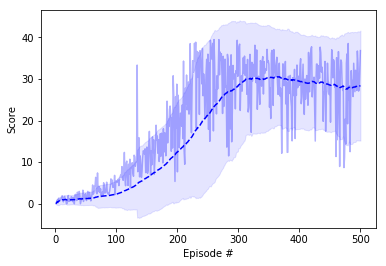

In [7]:
plot_scores(scores, avg_scores, std)

The agent solves the task in 315 episodes.

In [16]:
path = 'checkpoints/DDPGAgent-28.40-500-20190110-223615/'

agent.load_weights(path + 'checkpointactor.pth',
                   path + 'checkpoint_critic.pth')

demo(agent, env)

Total score (averaged over agents) this episode: 35.46999920718372


In [ ]:
env.close()

## Future improvements
The following future improvements should be implemented:
- Test new algorithms such as A2C, A3C, PPO, TRPO etc...
- Implement a prioritized replay buffer for the critic
- Implement GAE to train the critic
- Try to solve the crawler task
- Optimize hyperparameters using, for instance, random sampling